# A. Load HyP3 SBAS Stack into MintPy

*Author: Alex Lewandowski; Alaska Satellite Facility*

**Load your previously downloaded HyP3 SBAS stack into MintPy.**

- Load an SBAS stack from many GeoTiffs into two HDF5 datasets
  - `geometryGeo.h5`
  - `ifgramStack.h5`
 
You only need to perform this step once. You will be able to configure and reconfigure the parameters of your time series analysis without having to reload the data.

This notebook will provide the option to delete your GeoTiffs once they are loaded by MintPy

---
## 0. Import Required Software

In [13]:
import base64
import contextlib
import csv
from datetime import datetime, timedelta
from getpass import getpass
import os
from pathlib import Path
from pprint import pprint
import re
import shutil
from typing import Union
import zipfile

import h5py
from ipyfilechooser import FileChooser
import numpy as np
from osgeo import gdal, osr
gdal.UseExceptions()

from pandas.core.frame import DataFrame
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import transform_bounds, transform
import rioxarray as rxr
from tqdm.notebook import tqdm
import urllib
import xarray as xr

from bokeh.plotting import figure, show, output_file, ColumnDataSource, output_notebook
from bokeh.models import LabelSet, Div
import bokeh.layouts

import ipywidgets as widgets
from ipywidgets import Layout

from mintpy.cli import view, tsview, plot_network, plot_transection, plot_coherence_matrix
import mintpy.plot_coherence_matrix
import mintpy.objects.insar_vs_gps
import mintpy.utils

import opensarlab_lib as osl

---
## 1. Create a Custom Config File Defining the Paths to the GeoTiffs

**Select the directory holding your MintPy-ready HyP3 data stack and/or MintPy directory from a previously loaded MintPy SBAS stack**
- Click the `Select` button
- Navigate to your data directory
- Click the `Select` button
- Confirm that the desired path appears in green text
- Click the `Change` button to alter your selection

In [14]:
path = Path.home()
fc = FileChooser(path)
display(fc)

FileChooser(path='/home/jovyan', filename='', title='', show_hidden=False, select_desc='Select', change_desc='…

**Define a project name and create a MintPy directory in which to store files output during our analysis**

In [15]:
# define the work directory
data_path = Path(fc.selected_path)
print(f"Work directory: {data_path}")

# define the MintPy time-series directory
mint_path = data_path / 'MintPy'
mint_path.mkdir(exist_ok=True)
print(f"MintPy directory: {mint_path}")

# define a project name
proj_name = input("Enter a project name: ")
custom_config_path = mint_path / f'{proj_name}.txt'
print(f"Custom config path: {custom_config_path}")

#create a directory in which to store plots
plot_path = mint_path / "plots"
plot_path.mkdir(exist_ok=True)

Work directory: /home/jovyan/AZ_burst_2
MintPy directory: /home/jovyan/AZ_burst_2/MintPy


Enter a project name:  az_2


Custom config path: /home/jovyan/AZ_burst_2/MintPy/az_2.txt


**Select your SBAS stack's HyP3 product type**

In [16]:
product_select = osl.select_parameter(
    [
        'INSAR_GAMMA',
        'INSAR_ISCE_BURST'
    ]
)
print("Select your SBAS stack's HyP3 product type")
display(product_select)

Select your SBAS stack's HyP3 product type


RadioButtons(layout=Layout(min_width='800px'), options=('INSAR_GAMMA', 'INSAR_ISCE_BURST'), value='INSAR_GAMMA…

**Define the paths to the GeoTiffs in a custom config**

In [17]:
burst = 'BURST' in product_select.value

config = f"""
mintpy.load.processor        = hyp3
##---------geometry datasets:
mintpy.load.demFile          = {data_path}/*/*_dem*.tif
mintpy.load.incAngleFile     = {data_path}/*/*_lv_theta*.tif
mintpy.load.azAngleFile      = {data_path}/*/*_lv_phi*.tif
mintpy.load.waterMaskFile    = {data_path}/*/*_water_mask*.tif
##---------interferogram datasets:
mintpy.load.unwFile          = {data_path}/*/*_unw_phase*.tif
mintpy.load.corFile          = {data_path}/*/*_corr*.tif
"""

if burst:
    config += f"mintpy.load.connCompFile     = {data_path}/*/*_conncomp*.tif"
    
print(config)
custom_config_path.write_text(config)


mintpy.load.processor        = hyp3
##---------geometry datasets:
mintpy.load.demFile          = /home/jovyan/AZ_burst_2/*/*_dem*.tif
mintpy.load.incAngleFile     = /home/jovyan/AZ_burst_2/*/*_lv_theta*.tif
mintpy.load.azAngleFile      = /home/jovyan/AZ_burst_2/*/*_lv_phi*.tif
mintpy.load.waterMaskFile    = /home/jovyan/AZ_burst_2/*/*_water_mask*.tif
##---------interferogram datasets:
mintpy.load.unwFile          = /home/jovyan/AZ_burst_2/*/*_unw_phase*.tif
mintpy.load.corFile          = /home/jovyan/AZ_burst_2/*/*_corr*.tif
mintpy.load.connCompFile     = /home/jovyan/AZ_burst_2/*/*_conncomp*.tif


604

---
## 2. Load the Data with MintPy

The output of the loading step is saved to the `MintPy/inputs` directory:
- ifgramStack.h5: 
- geometryGeo.h5

In [18]:
!smallbaselineApp.py $custom_config_path --work-dir {mint_path} --dostep load_data

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-03-14 23:09:23.434495--
Current directory: /home/jovyan/opensarlab_MintPy_Recipe_Book
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: az_2
Go to work directory: /home/jovyan/AZ_burst_2/MintPy
copy default template file /home/jovyan/.local/envs/osl_mintpy/lib/python3.9/site-packages/mintpy/defaults/smallbaselineApp.cfg to work directory
read custom template file: /home/jovyan/AZ_burst_2/MintPy/az_2.txt
update default template based on input custom template
    mintpy.load.processor: auto --> hyp3
    mintpy.load.unwFile: auto --> /home/jovyan/AZ_burst_2/*/*_unw_phase*.t

In [19]:
inputs_path = mint_path/'inputs'
!ls $inputs_path

az_2.txt  geometryGeo.h5  ifgramStack.h5  smallbaselineApp.cfg


---
## 3. Run the Modify Network Step

- Identifies and excludes interferograms (i.e. affected by coherence phase-unwrapping errors) before the network inversion

In [20]:
!smallbaselineApp.py $custom_config_path --work-dir {mint_path} --dostep modify_network

MintPy version 1.5.3, date 2023-11-23
--RUN-at-2024-03-14 23:09:27.684066--
Current directory: /home/jovyan/opensarlab_MintPy_Recipe_Book
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: az_2
Go to work directory: /home/jovyan/AZ_burst_2/MintPy
read custom template file: /home/jovyan/AZ_burst_2/MintPy/az_2.txt
update default template based on input custom template
No new option value found, skip updating /home/jovyan/AZ_burst_2/MintPy/smallbaselineApp.cfg
read default template file: /home/jovyan/AZ_burst_2/MintPy/smallbaselineApp.cfg


******************** step - modify_network ********************
Input data seems to be geocoded. Lo

---
## 4. Plot the interferogram network

Running **plot_network** gives an overview of the network and the average coherence of the stack. The program creates multiple files as follows:
- `ifgramStack_coherence_spatialAvg.txt`: Contains interferogram dates, average coherence temporal and spatial baseline separation.
- `Network.pdf`: Displays the network of interferograms on time-baseline coordinates, colorcoded by avergae coherence of the interferograms. 
- `CoherenceMatrix.pdf` shows the avergae coherence pairs between all available pairs in the stack.

read temporal/spatial baseline info from file: /home/jovyan/AZ_burst_2/MintPy/inputs/ifgramStack.h5
open ifgramStack file: ifgramStack.h5
coherenceSpatialAvg.txt already exists, read it directly
number of acquisitions: 23
number of interferograms: 22
shift all perp baseline by -87.93682861328125 to zero mean for plotting
--------------------------------------------------
number of interferograms marked as drop: 0
number of interferograms marked as keep: 22
number of acquisitions marked as drop: 0
max perpendicular baseline: 330.29 m
max temporal      baseline: 12.0 days
showing coherence
data range: [0.929, 0.9815]
display range: (0.2, 1.0)
showing ...


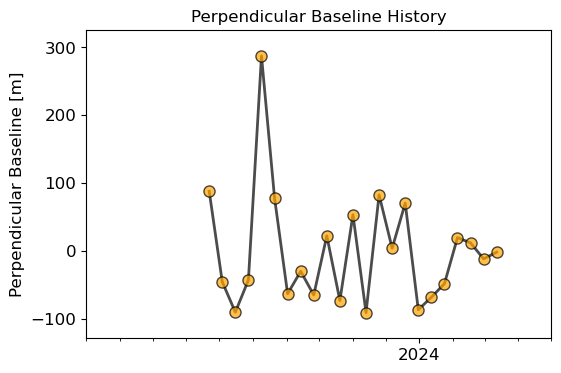

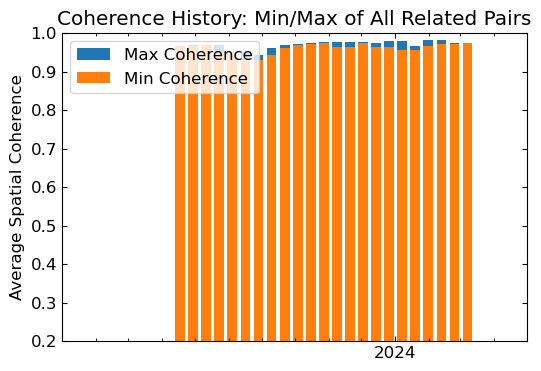

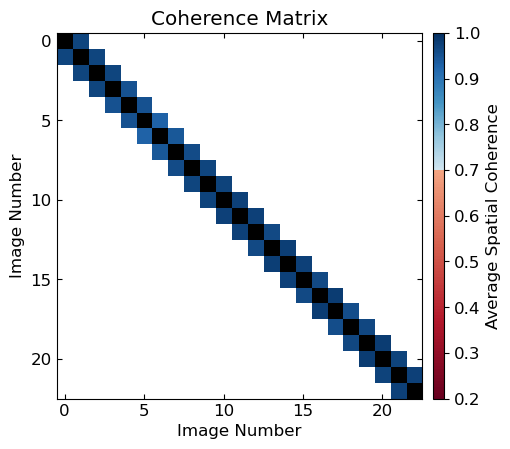

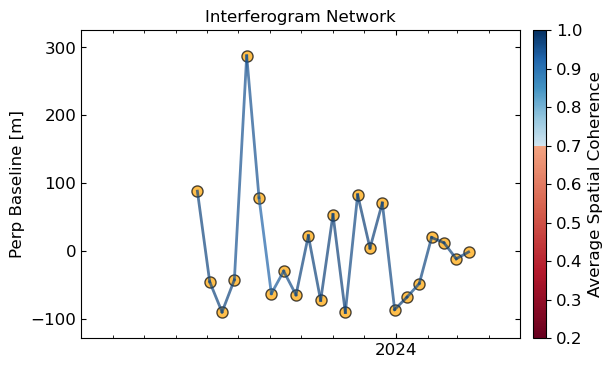

In [21]:
%matplotlib inline
with osl.work_dir(mint_path):
    scp_args = f'{inputs_path}/ifgramStack.h5 --cmap-vlist 0.2 0.7 1.0'
    plot_network.main(scp_args.split())
    plots = ['bperpHistory.pdf', 'coherenceHistory.pdf', 'coherenceMatrix.pdf', 'network.pdf']
    for p in plots:
        if (mint_path/p).exists():
            (mint_path/p).rename(f'{plot_path}/{p}')

---
# 5. Delete Input Data

Once MintPy has loaded the data into HDF5 datasets, you may wish to delete the input data to conserve storage space. 

You can adjust configuration parameters and update your analysis without reloading the data from their original source.

In [22]:
s1_paths = list(data_path.glob('S1*'))
pprint(f'S1 directories: {s1_paths}')

('S1 directories: '
 "[PosixPath('/home/jovyan/AZ_burst_2/S1_056723_IW3_20230926_20231008_VV_INT80_CFDE'), "
 "PosixPath('/home/jovyan/AZ_burst_2/S1_056723_IW3_20240205_20240217_VV_INT80_2CF4'), "
 "PosixPath('/home/jovyan/AZ_burst_2/S1_056723_IW3_20231219_20231231_VV_INT80_455E'), "
 "PosixPath('/home/jovyan/AZ_burst_2/S1_056723_IW3_20230821_20230902_VV_INT80_DE5F'), "
 "PosixPath('/home/jovyan/AZ_burst_2/S1_056723_IW3_20231231_20240112_VV_INT80_CF71'), "
 "PosixPath('/home/jovyan/AZ_burst_2/S1_056723_IW3_20230902_20230914_VV_INT80_850C'), "
 "PosixPath('/home/jovyan/AZ_burst_2/S1_056723_IW3_20231020_20231101_VV_INT80_7736'), "
 "PosixPath('/home/jovyan/AZ_burst_2/S1_056723_IW3_20231125_20231207_VV_INT80_FC0C'), "
 "PosixPath('/home/jovyan/AZ_burst_2/S1_056723_IW3_20230622_20230704_VV_INT80_A8BE'), "
 "PosixPath('/home/jovyan/AZ_burst_2/S1_056723_IW3_20230914_20230926_VV_INT80_A8A3'), "
 "PosixPath('/home/jovyan/AZ_burst_2/S1_056723_IW3_20240229_20240312_VV_INT80_C547'), "
 "PosixPath

In [23]:
cleanup_select = osl.select_parameter(
    [
        'Delete S1 directories',
        'Save S1 directories'
    ]
)
print("Save or delete input data:")
display(cleanup_select)

Save or delete input data:


RadioButtons(layout=Layout(min_width='800px'), options=('Delete S1 directories', 'Save S1 directories'), value…

In [24]:
if 'Delete' in cleanup_select.value:
    for d in s1_paths:
        shutil.rmtree(d)